In [69]:
import numpy as np

from matplotlib import pyplot as plt

In [34]:
# test data

iranks = np.array([
    [1],
    [2],
    [3]
])
ifeats = np.array([
    [1],
    [2],
    [3]
])


In [89]:
def calc_l2_distances(pt, points):
    return ((points - pt) ** 2).sum(axis=1)

def calc_sum_ord_distances(pt, points, sum_ord=0):
    return np.partition(points + pt, sum_ord)[:,sum_ord]

pt = np.array([1, 2, 3])
pts = np.array([
    [4, 0, 1],
    [7, 6, 5],
    [5, 5, 0]
])
assert np.all(calc_sum_ord_distances(pt, pts, 1) == np.array([4, 8, 6]))
assert np.all(calc_sum_ord_distances(pt, pts, 0) == np.array([2, 8, 3]))



In [67]:
def estimate_disorder_curve(item_features, item_ranks, item_item_rank_lim=None,
                            base_item_cout=1000, sample_count=1000, metric_type="l2"):
    assert metric_type in ["l2", ""]
    item_count, query_count = item_ranks.shape
    if item_item_rank_lim is None:
        item_item_rank_lim = item_count - 1
    base_items = np.random.choice(item_count, base_item_cout)
    disorder_multipliers = []

    for base_item in base_items:
#         print(base_item)
        distances = ((item_features - item_features[base_item]) ** 2).sum(axis=1)
#         print(distances)
        item_order = np.argsort(distances)
        assert item_order[0] == base_item # fails if duplicates
        item_item_ranks = np.argsort(item_order)
        item_order = item_order[1: 1 + item_item_rank_lim]
#         print(item_order)
#         print(item_item_ranks)
        
        second_items = np.random.choice(item_order, sample_count)
        qweries = np.random.choice(query_count, sample_count)
#         print(second_items, qweries)
        base_item_ranks = item_ranks[base_item, qweries]
        second_item_ranks = item_ranks[second_items, qweries]
#         print(base_item_ranks, second_item_ranks)
        disorder_multipliers.append(
            item_item_ranks[second_items] / (base_item_ranks + second_item_ranks)
        )
    disorder_multipliers = np.array(disorder_multipliers).flatten()
#     print()
#     print(disorder_multipliers)
    return np.percentile(disorder_multipliers, np.arange(0, 101))

In [70]:
curve = estimate_disorder_curve(ifeats, iranks, base_item_cout=1, sample_count=1)

In [75]:
item_count = 10 ** 6
query_count = 1000

ifeats = np.fromfile("collections/data/model_scores/scores_train.bin", dtype="float32"
                    ).reshape(item_count, query_count)
iranks = np.fromfile("collections/data/item_train_ranks.bin", dtype="float32"
                    ).reshape(item_count, query_count)

In [78]:
curve = estimate_disorder_curve(ifeats, iranks, base_item_cout=10, sample_count=10000, item_item_rank_lim=10000)

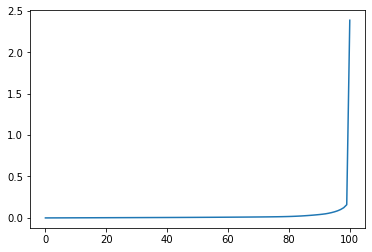

In [79]:
plt.plot(curve)


list:
label, metric_calcer

in cycle:
    label, features, item_metric, item_ranks

In [ ]:
def plot_disorder_curves(metrics_to_eval, dataset, dataset_part="train"):
    assert dataset_part in ["train", "test"]
    item_ranks = np.fromfile(
        "{}/data/item_train_ranks.bin".format(dataset),
        dtype="float32").reshape(item_count, query_count)
    item__log_ranks = np.fromfile(
        "{}/data/item_train_log_ranks.bin".format(dataset),
        dtype="float32").reshape(item_count, query_count)
    

In [32]:
a = np.arange(5)
a[2:7]

array([2, 3, 4])

In [83]:
A[:,2]

array([2, 5, 8])

In [29]:
A = np.arange(9).reshape((3, 3))
A[[0, 1, 2], 0]

array([0, 3, 6])

In [24]:
np.random.choice(3, 3, replace=True)

array([0, 1, 0])

In [80]:
help(np.partition)

Help on function partition in module numpy:

partition(a, kth, axis=-1, kind='introselect', order=None)
    Return a partitioned copy of an array.
    
    Creates a copy of the array with its elements rearranged in such a
    way that the value of the element in k-th position is in the
    position it would be in a sorted array. All elements smaller than
    the k-th element are moved before this element and all equal or
    greater are moved behind it. The ordering of the elements in the two
    partitions is undefined.
    
    .. versionadded:: 1.8.0
    
    Parameters
    ----------
    a : array_like
        Array to be sorted.
    kth : int or sequence of ints
        Element index to partition by. The k-th value of the element
        will be in its final sorted position and all smaller elements
        will be moved before it and all equal or greater elements behind
        it. The order of all elements in the partitions is undefined. If
        provided with a sequence of k-